In [2]:
%cd D:\Project\Data_Speech
!ls

D:\Project\Data_Speech
LibriTTS
ViMD_Dataset
combine
kkrTTS
single_speaker
viVoice


In [3]:
import re
import os
import librosa
import soundfile as sf
from datasets import load_dataset, Audio

In [ ]:
data_dir = "viVoice"
output_dir = os.path.join(data_dir, "wav")
metadata_path = os.path.join(data_dir, "metadata.txt")
channel_name = '@betterversionvn' #<= extract this channel

In [ ]:
df = load_dataset(
    'parquet',
    data_files=f"./{data_dir}/data/*.parquet", #<= pre-download parquet and load locally
    cache_dir=f"./{data_dir}/tmp/hf_temp_cache", #<= cache dỉr
    split='train', num_proc=8
)
df = df.cast_column("audio", Audio())

Resolving data files:   0%|          | 0/354 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/348 [00:00<?, ?it/s]

In [5]:
#Util functions

def text_norm(text):
    punctuation = ["，", "、", "،", "．", "。"]
    map_to = ","
    punctuation_pattern = re.compile(f"[{''.join(re.escape(p) for p in punctuation)}]")
    #replace punctuation that acts like a comma or period
    text = punctuation_pattern.sub(map_to, text)
    #replace consecutive whitespace chars with a single space and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def sample_rate_norm(audio, sr):
    if sr != 24000:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=24000)
    return audio

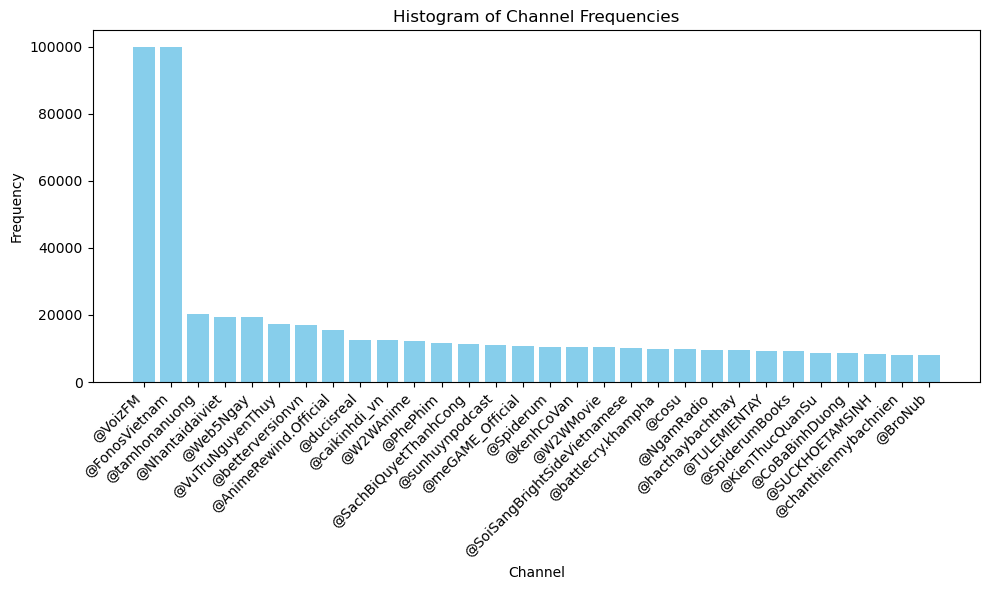

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

channel_counts = Counter(df['channel'])
channels, counts = zip(*channel_counts.most_common(30))

plt.figure(figsize=(10, 6))
plt.bar(channels, counts, color='skyblue')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.title('Histogram of Channel Frequencies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
text_col_name = 'text'

os.makedirs(output_dir, exist_ok=True)

with open(metadata_path, 'w', encoding='utf-8') as meta_file:
    print(f"Extracting {channel_name}")
    for i in range(len(df)):
        row = df[i]
        if row['channel'] == channel_name:
            #Audio
            audio_array = row['audio']['array']
            original_sr = row['audio']['sampling_rate']
            audio_24k = sample_rate_norm(audio_array, original_sr)

            wav_path = os.path.join(output_dir, f"{i}.wav")
            sf.write(wav_path, audio_24k, 24000)

            #Text
            transcript = text_norm(row[text_col_name])
            meta_file.write(f"{channel_name[1:]}/wav/{i}.wav|{transcript}\n")
        else:
            continue